In [575]:
%config Completer.use_jedi = False
from pymongo import MongoClient
import pandas as pd
import datetime as dt
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

client = MongoClient('localhost', 27017)
db = client.resilient

# r/all Analysis

## Connecting to the r/all comment collection.

In [555]:
all_comments = db.all

## Getting the number of comments in the collection.

In [556]:
print(f'There are {all_comments.estimated_document_count():,} r/all comments.')

There are 5,300,000 r/all comments.


## Counting the number of comments for each author.

In [557]:
all_comments_per_author = pd.DataFrame(all_comments.aggregate([
    {'$project': {'_id': 1, 'author': 1}}, # Only using author field.
    {'$group': {'_id': '$author', 'num_comments': {'$sum': 1}}},
    {'$sort': {'num_comments': -1}} # Sort descending.
], allowDiskUse=True))

print(
    all_comments_per_author.head(),
    all_comments_per_author.shape,
    '--- Number of comments per author. ---',
    sep='\n\n'
)

                  _id  num_comments
0       AutoModerator        172089
1              FMKBot         15321
2   MangaDexStatsBot2          6839
3  KickOpenTheDoorBot          3061
4         QualityVote          2404

(1574237, 2)

--- Number of comments per author. ---


## Counting the number of comments in each subreddit.

In [558]:
all_comments_per_subreddit = pd.DataFrame(all_comments.aggregate([
    {'$project': {'_id': 1, 'subreddit': 1}},
    {'$group': {'_id': '$subreddit', 'num_comments': {'$sum': 1}}},
    {'$sort': {'num_comments': -1}}
], allowDiskUse=True))

print(
    all_comments_per_subreddit.head(),
    all_comments_per_subreddit.shape,
    '--- Number of comments per subreddit. ---',
    sep='\n\n'
)

             _id  num_comments
0      AskReddit        151603
1      worldnews         69009
2      Eldenring         60604
3      teenagers         55179
4  AmItheAsshole         52846

(69467, 2)

--- Number of comments per subreddit. ---


## Counting the number of comments per hour for a specific subreddit.

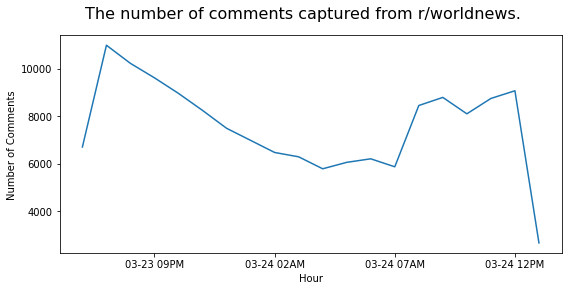

In [565]:
subreddit = 'AskReddit'

selected_comments = pd.DataFrame(all_comments.find({'subreddit': {'$eq': subreddit}}))

daily = pd.to_datetime(selected_comments['created_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central') \
    .round('H') \
    .value_counts()

daily = daily.sort_index()

start = daily.index[0]
end = daily.index[-1]

daily = pd.DataFrame(daily) \
    .reindex(pd.date_range(start, end, freq='H'), fill_value=0)

# Graph code.
plt.figure(figsize=(9, 4))
plt.suptitle(f'The number of comments captured from r/{subreddit}.', fontsize=16)
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Number of Comments', fontsize=10)
plt.plot(daily)
ax = plt.gca()
matplotlib.rcParams['timezone'] = 'US/Central'
ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %I%p'))
plt.show()

# r/popular Analysis

## Connecting to r/popular snapshots collection.

In [560]:
popular_snapshots = db.popular

## Grouping r/popular thread IDs, identifying their subreddit, and listing their snapshots (along with snapshot attributes).

Each thread should come with their first timestamp (`min_utc`), last timestamp (`max_utc`), and the number of seconds in between known as the thread's lifespan (`lifespan`).

In [561]:
# pt: r/popular threads with their subreddit and associated snapshots.
popular_threads = pd.DataFrame(popular_snapshots.aggregate([
    {'$sort': {'retrieved_utc': 1}},
    {'$group': {'_id': '$id',
                'subreddit': {'$first': '$subreddit'},
                'created_utc': {'$first': '$created_utc'},
                'num_snapshots': {'$sum': 1},
                'max_utc': {'$max': '$retrieved_utc'},
                'min_utc': {'$min': '$retrieved_utc'},
                'snapshots': {'$push': 
                              {'retrieved_utc': '$retrieved_utc',
                               'rank': '$rank',
                               'score': '$score',
                               'upvote_ratio': '$upvote_ratio',
                               'num_comments': '$num_comments'}}}},
    {'$sort': {'num_snapshots': -1}}
], allowDiskUse=True)).rename(columns={'_id': 'id'})

popular_threads['datetime'] = \
    pd.to_datetime(popular_threads['created_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['max_datetime'] = \
    pd.to_datetime(popular_threads['max_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['min_datetime'] = \
    pd.to_datetime(popular_threads['min_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

popular_threads['lifespan'] = popular_threads['max_utc'] - popular_threads['min_utc']

print(
    popular_threads[['id', 'subreddit', 'num_snapshots']].head(),
    popular_threads.shape,
    popular_threads.dtypes,
    '--- Snapshots grouped by threads. ---',
    sep='\n\n'
)

       id        subreddit  num_snapshots
0  tl8li5           videos            507
1  tldlqk   wallstreetbets            480
2  tl1855  HermanCainAward            476
3  tlk5pt        byebyejob            474
4  tlkufr      nottheonion            452

(457, 11)

id                                   object
subreddit                            object
created_utc                         float64
num_snapshots                         int64
max_utc                               int64
min_utc                               int64
snapshots                            object
datetime         datetime64[ns, US/Central]
max_datetime     datetime64[ns, US/Central]
min_datetime     datetime64[ns, US/Central]
lifespan                              int64
dtype: object

--- Snapshots grouped by threads. ---


## Aggregating r/popular threads per subreddit to provide descriptive measures.

In [562]:
popular_describe_subreddits = popular_threads.groupby('subreddit') \
    .agg({'lifespan': 'mean',
          'id': 'count',
          'num_snapshots': 'sum'}) \
    .rename(columns={'id': 'num_threads', 'lifespan': 'average_lifespan'}) \
    .astype(int) \
    .sort_values(by='num_threads', ascending=False)

print(
    popular_describe_subreddits.head(10),
    popular_describe_subreddits.shape,
    '--- Description of r/popular threads per subreddit.',
    sep='\n\n'
)

                    average_lifespan  num_threads  num_snapshots
subreddit                                                       
worldnews                      13376           11           1160
nextfuckinglevel               11678            9            835
HolUp                          10685            9            782
shitposting                     5540            9            417
memes                           8770            9            525
interestingasfuck              17886            8           1155
Unexpected                     15276            8            670
antiwork                       12009            7            658
WhitePeopleTwitter             12444            7            683
PublicFreakout                 15624            7            842

(202, 3)

--- Description of r/popular threads per subreddit.


## For a specific r/popular thread, graph it's rank trajectory.

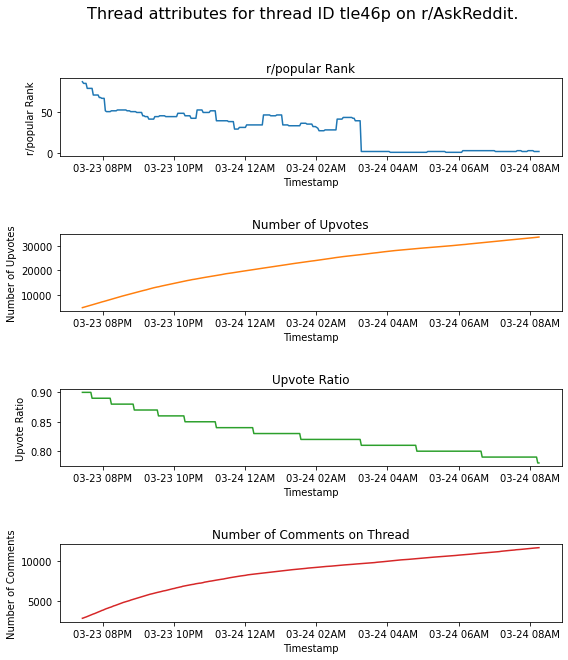

In [571]:
# Get a random r/popular thread.
thread = popular_threads.sample(n=1)
thread_id = thread['id'].values[0]
subreddit = thread['subreddit'].values[0]

snapshots = popular_threads[popular_threads['id'] == thread_id]['snapshots'].values[0]

snapshots = pd.DataFrame(snapshots).sort_values(by='retrieved_utc')

snapshots['datetime'] = pd.to_datetime(snapshots['retrieved_utc'], unit='s') \
    .dt.tz_localize('UTC') \
    .dt.tz_convert('US/Central')

# Graph code.
fig, ax = plt.subplots(4, 1, figsize=(9, 10))
fig.suptitle(f'Thread attributes for thread ID {thread_id} on r/{subreddit}.', fontsize=16)

fig.subplots_adjust(hspace=1)

ax[0].plot(snapshots['datetime'], snapshots['rank'], color='tab:blue')
ax[0].title.set_text('r/popular Rank')
ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel('r/popular Rank')
ax[0].xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %I%p'))


ax[1].plot(snapshots['datetime'], snapshots['score'], color='tab:orange')
ax[1].title.set_text('Number of Upvotes')
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('Number of Upvotes')
ax[1].xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %I%p'))

ax[2].plot(snapshots['datetime'], snapshots['upvote_ratio'], color='tab:green')
ax[2].title.set_text('Upvote Ratio')
ax[2].set_xlabel('Timestamp')
ax[2].set_ylabel('Upvote Ratio')
ax[2].xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %I%p'))

ax[3].plot(snapshots['datetime'], snapshots['num_comments'], color='tab:red')
ax[3].title.set_text('Number of Comments on Thread')
ax[3].set_xlabel('Timestamp')
ax[3].set_ylabel('Number of Comments')
ax[3].xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax[3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %I%p'))

matplotlib.rcParams['timezone'] = 'US/Central'


plt.show()

## Number of r/popular threads on the feed for a specific subreddit.

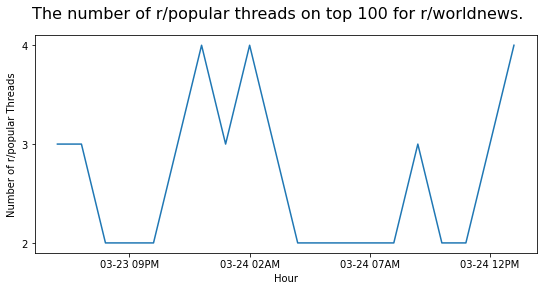

In [576]:
subreddit = 'worldnews'

popular_ranges = popular_threads[popular_threads['subreddit'] == subreddit][['min_datetime', 'max_datetime']]
popular_ranges['start_hour'] = popular_ranges['min_datetime'].dt.round('H')
popular_ranges['end_hour'] = popular_ranges['max_datetime'].dt.round('H')


start = popular_ranges['start_hour'].min()
end = popular_ranges['end_hour'].max()

date_index = pd.date_range(start, end, freq='H')

popular_feed_count = pd.DataFrame(index=date_index,
                                  columns=['num_popular'],
                                  data=[0 for _ in range(len(date_index))])

for row in popular_ranges.itertuples():
    for hour in pd.date_range(row.start_hour, row.end_hour, freq='H'):
        popular_feed_count.loc[hour] += 1

plt.figure(figsize=(9, 4))
plt.suptitle(f'The number of r/popular threads on top 100 for r/{subreddit}.', fontsize=16)
plt.xlabel('Hour', fontsize=10)
plt.ylabel('Number of r/popular Threads', fontsize=10)
plt.plot(popular_feed_count)

ax = plt.gca()
matplotlib.rcParams['timezone'] = 'US/Central'
ax.xaxis.set_major_locator(mdates.HourLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %I%p'))

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()